# Gaussian or lognormal?

Within a species, the distribution of many measurements is well modeled by a Gaussian distribution.
But for some measurements a lognormal distribution is a better fit.
For other measurements both models fit well, and for others, neither does.

These observations suggest several questions:

* Why might these distributions follow either model?

* Why do some fit a Gaussian and others a lognormal?

* How can we best determine which is a better fit.

I address the first two questions in Chapters 1 and 4 of [*Probably Overthinking It*](https://greenteapress.com/wp/probably-overthinking-it/).
This notebook addresses the third, by suggesting a way to fit these models to an observed dataset and to evaluate the fit.

As examples, I'll use two datasets:

* The Anthropometric Survey of US Army Personnel (ANSUR II), available from [the Open Design Lab at Penn State](https://www.openlab.psu.edu/).

* Results of medical blood tests from [supplemental material](https://www.degruyter.com/document/doi/10.1515/labmed-2020-0005/html) from "Quantitative laboratory results: normal or lognormal distribution?" by Frank Klawonn , Georg Hoffmann and Matthias Orth.

The following cells install packages and download the files we'll need.

In [1]:
# install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

## ANSUR Data

The ANSUR dataset contains 93 measurements from 4082 male and 1986 female members of the U.S. armed forces.


In [4]:
download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIFEMALEPublic.csv"
)
download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIMALEPublic.csv"
)

In [5]:
ansur_female = pd.read_csv("ANSURIIFEMALEPublic.csv", encoding="ISO-8859-1")
ansur_female.shape

(1986, 108)

In [6]:
ansur_male = pd.read_csv("ANSURIIMALEPublic.csv", encoding="ISO-8859-1")
ansur_male.shape

(4082, 108)

In [7]:
ansur_male.columns

Index(['subjectid', 'abdominalextensiondepthsitting', 'acromialheight',
       'acromionradialelength', 'anklecircumference', 'axillaheight',
       'balloffootcircumference', 'balloffootlength', 'biacromialbreadth',
       'bicepscircumferenceflexed',
       ...
       'Branch', 'PrimaryMOS', 'SubjectsBirthLocation', 'SubjectNumericRace',
       'Ethnicity', 'DODRace', 'Age', 'Heightin', 'Weightlbs',
       'WritingPreference'],
      dtype='object', length=108)

The measurements are the columns in all lowercase.

In [61]:
measurements = [column for column in ansur_female.columns if column.lower() == column]
measurements

['abdominalextensiondepthsitting',
 'acromialheight',
 'acromionradialelength',
 'anklecircumference',
 'axillaheight',
 'balloffootcircumference',
 'balloffootlength',
 'biacromialbreadth',
 'bicepscircumferenceflexed',
 'bicristalbreadth',
 'bideltoidbreadth',
 'bimalleolarbreadth',
 'bitragionchinarc',
 'bitragionsubmandibulararc',
 'bizygomaticbreadth',
 'buttockcircumference',
 'buttockdepth',
 'buttockheight',
 'buttockkneelength',
 'buttockpopliteallength',
 'calfcircumference',
 'cervicaleheight',
 'chestbreadth',
 'chestcircumference',
 'chestdepth',
 'chestheight',
 'crotchheight',
 'crotchlengthomphalion',
 'crotchlengthposterioromphalion',
 'earbreadth',
 'earlength',
 'earprotrusion',
 'elbowrestheight',
 'eyeheightsitting',
 'footbreadthhorizontal',
 'footlength',
 'forearmcenterofgriplength',
 'forearmcircumferenceflexed',
 'forearmforearmbreadth',
 'forearmhandlength',
 'functionalleglength',
 'handbreadth',
 'handcircumference',
 'handlength',
 'headbreadth',
 'headcir

In [62]:
len(measurements)

93

The following function takes a `Series` and uses a [soft L1 norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) to minimize the area between the data and a Gaussian model.

In [63]:
from empiricaldist import Cdf
from scipy.optimize import least_squares
from scipy.stats import norm


def fit_model(series, verbose=False):
    """Find the model that minimizes the errors in percentiles."""

    def error_func(params):
        error = np.abs(ps - norm.cdf(qs, *params))
        if verbose:
            print(params, np.sum(error))
        return error

    x0 = series.mean(), series.std()
    low, high = series.quantile([0.01, 0.99])

    cdf = Cdf.from_seq(series)
    qs = np.linspace(low, high)
    ps = cdf(qs)

    res = least_squares(error_func, x0=x0, xtol=1e-3, loss="soft_l1")
    assert res.success
    mu, sigma = res.x
    return norm(mu, sigma)

As an example, let's fit the distribution of male heights.

In [64]:
series = ansur_male["stature"]
dist = fit_model(series, verbose=True)

[1756.21460069   68.55078767] 0.1821344487296781
[1756.21462686   68.55078767] 0.18213631155601778
[1756.21460069   68.55078869] 0.18213448100538832
[1755.57429829   68.2097861 ] 0.1548211165158396
[1755.57432445   68.2097861 ] 0.15482069994677106
[1755.57429829   68.20978712] 0.15482109146464754


The parameters that minimize the area between curves are slightly different from the ones that match moments.

The following function computes the area between curves in terms of the average error in percentile points.

In [65]:
def average_error(series):
    """Area between a CDF and a Gaussian model.

    series: sequence of numbers
    """
    dist = fit_model(series)
    cdf = Cdf.from_seq(series)

    low, high = series.quantile([0.01, 0.99])
    qs = np.linspace(low, high)

    error = cdf(qs) - dist.cdf(qs)
    return np.mean(np.abs(error)) * 100

In [66]:
average_error(series)

0.3096422330316792

This function makes a plot that shows the area between the model and the curve.

In [67]:
def make_plot(series, **options):
    """Plot the CDF of a series with a Gaussian model.

    series: sequence of numbers
    """
    dist = fit_model(series)
    cdf = Cdf.from_seq(series)
    qs = cdf.index
    ps = dist.cdf(qs)

    plt.fill_between(qs, ps, cdf.values, color="gray", alpha=0.4)
    cdf.plot(lw=1, **options)
    decorate(ylabel="CDF")

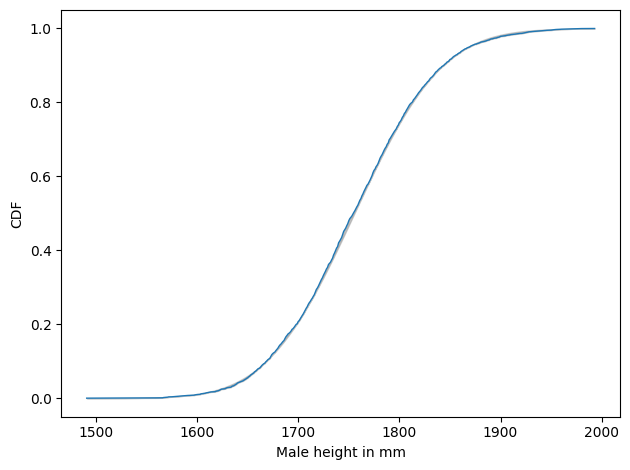

In [68]:
make_plot(series)
decorate(xlabel="Male height in mm")

Now let's loop through the measurements and find the best Gaussian model for each.

In [69]:
def all_errors(df, tag, measurements, log=False):
    """ """
    res = []

    for varname in measurements:
        series = df[varname]
        if log:
            series = np.log10(series)
        mae = average_error(series)
        res.append((mae, tag, varname))

    return pd.DataFrame(res, columns=["error", "sex", "measurement"])

In [70]:
res_female = all_errors(ansur_female, "female", measurements)
res_male = all_errors(ansur_male, "male", measurements)

gaussian = pd.concat([res_female, res_male])

With the `log=True` argument, `all_errors` fits a Gaussian model to the logarithms of the values, which is the same as fitting a lognormal distribution to the values.

In [71]:
res_female_log = all_errors(ansur_female, "female", measurements, log=True)
res_male_log = all_errors(ansur_male, "male", measurements, log=True)

lognormal = pd.concat([res_female_log, res_male_log])

Now we'll join the two data frames, so for each measurement we'll have the results for the Gaussian and lognormal models.

In [72]:
def join(gaussian, lognormal):
    """ """
    joined = gaussian.merge(
        lognormal, on=["measurement", "sex"], suffixes=("_gaussian", "_lognormal")
    )
    joined["diff"] = joined["error_gaussian"] - joined["error_lognormal"]
    joined["sum"] = joined["error_gaussian"] + joined["error_lognormal"]
    return joined

In [73]:
joined = join(gaussian, lognormal)

The following scatter plot shows the expected error of the Gaussian model on the x-axis and the expected error of the lognormal model on the y-axis. 

In [80]:
def scatterplot(joined):
    """ """
    high1 = joined["error_gaussian"].max()
    high2 = joined["error_lognormal"].max()
    high = max(high1, high2) * 1.05
    xs = np.linspace(0, high)

    options = dict(lw=1, color="gray", alpha=0.4)
    plt.plot(xs, xs, **options)
    plt.plot(xs, xs + 0.5, ':', **options)
    plt.plot(xs, xs - 0.5, ':', **options)
    plt.text(0.1, 2, "Gaussian better")
    plt.text(1.8, 0.2, "lognormal better")

    plt.plot(joined["error_gaussian"], joined["error_lognormal"], ".", alpha=0.4)
    decorate(
        xlabel="MAE in percentile rank, Gaussian",
        ylabel="MAE in percentile rank, lognormal",
        xlim=[0, high],
        ylim=[0, high],
    )

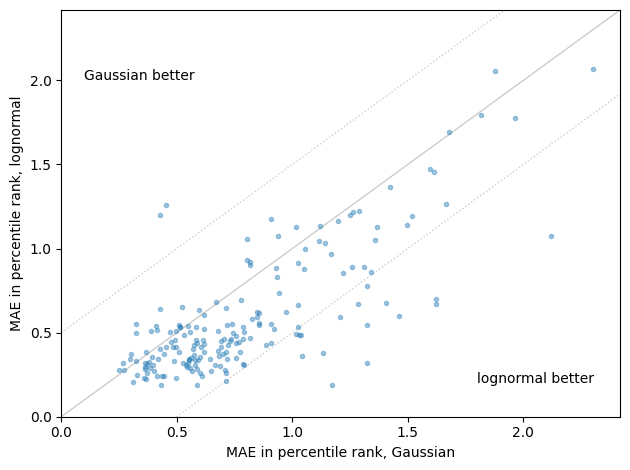

In [81]:
scatterplot(joined)
plt.savefig("log_vs_normal5.png", dpi=300)

* Points in the lower left are measurements where both models are good.

* Points in the upper right are measurements where both models are bad.

* In the upper left, the Gaussian model is better.

* In the lower right, the lognormal model is better.

In [23]:
joined.sort_values(by="diff", inplace=True)

In [24]:
def make_double_plot(series, xlabel=""):
    """Plot Gaussian and lognormal models for a given Series

    series: sequence of numbers
    xlabel: string label for the x-axis

    """
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    make_plot(series, label="Gaussian")
    decorate(ylabel="Percentile Rank", xlabel=xlabel)

    plt.subplot(1, 2, 2)
    make_plot(np.log10(series), label="lognormal")
    decorate(xlabel=xlabel + " (log10)")

    plt.tight_layout()

Here's one of the few examples where the Gaussian model is better.

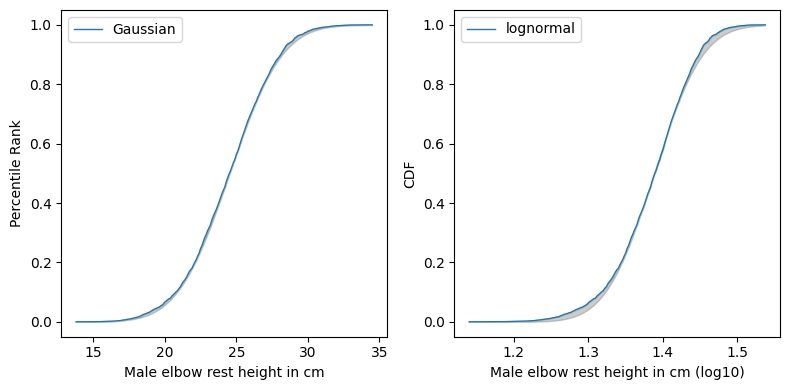

In [25]:
# Gaussian better

series = ansur_male["elbowrestheight"] / 10
make_double_plot(series, "Male elbow rest height in cm")
plt.savefig("log_vs_normal1.png", dpi=300)

In [26]:
joined.tail()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
180,1.620303,male,waistdepth,0.702878,0.917425,2.323182
0,1.623475,female,abdominalextensiondepthsitting,0.667677,0.955798,2.291152
183,1.170825,male,weightkg,0.189704,0.981121,1.360530
90,1.322391,female,weightkg,0.319606,1.002785,1.641997
87,2.120735,female,waistdepth,1.077030,1.043705,3.197765


Here's one of several where the lognormal model is better.

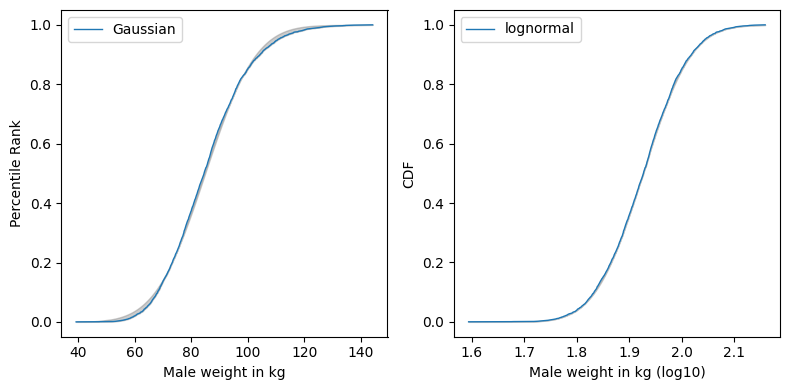

In [27]:
# lognormal better

series = ansur_male["weightkg"] / 10
make_double_plot(series, "Male weight in kg")
plt.savefig("log_vs_normal2.png", dpi=300)

In [28]:
joined.sort_values(by="sum", inplace=True)
joined.head()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
167,0.309642,male,stature,0.206610,0.103032,0.516253
185,0.250212,male,wristheight,0.275790,-0.025578,0.526002
156,0.271811,male,overheadfingertipreachsitting,0.275191,-0.003380,0.547002
97,0.327813,male,axillaheight,0.246388,0.081426,0.574201
163,0.266334,male,sittingheight,0.320184,-0.053850,0.586517


Here's an example where both are good.

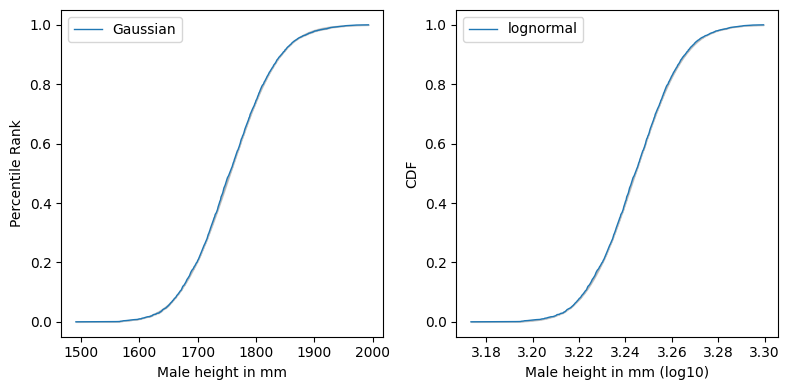

In [29]:
# both good

series = ansur_male["stature"]
make_double_plot(series, "Male height in mm")
plt.savefig("log_vs_normal3.png", dpi=300)

In [30]:
joined.tail(10)

,error_gaussian,sex,measurement,error_lognormal,diff,sum
104,1.424293,male,bimalleolarbreadth,1.364131,0.060163,2.788424
48,1.664536,female,heelbreadth,1.263076,0.401461,2.927612
41,1.611503,female,handbreadth,1.453697,0.157807,3.065200
30,1.598110,female,earlength,1.470811,0.127298,3.068921
87,2.120735,female,waistdepth,1.077030,1.043705,3.197765
122,1.676438,male,earbreadth,1.692780,-0.016342,3.369218
11,1.816925,female,bimalleolarbreadth,1.795962,0.020964,3.612887
124,1.965292,male,earprotrusion,1.773712,0.191580,3.739004
29,1.879525,female,earbreadth,2.053329,-0.173804,3.932854
31,2.303347,female,earprotrusion,2.067253,0.236094,4.370600


Here's an example where both are bad.

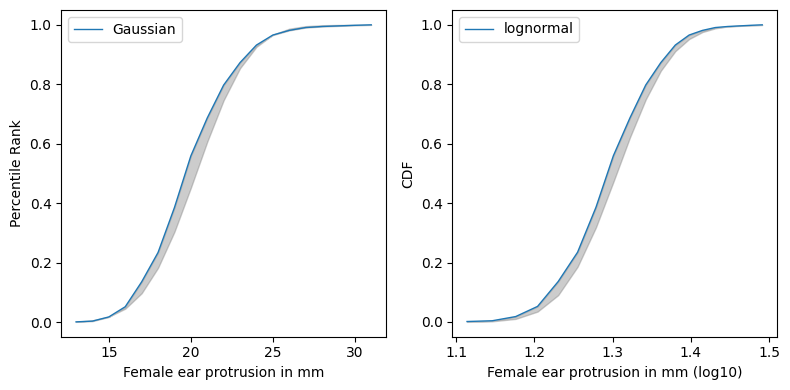

In [31]:
# both bad

series = ansur_female["earprotrusion"]
make_double_plot(series, "Female ear protrusion in mm")
plt.savefig("log_vs_normal4.png", dpi=300)

## Lab Results

This section reports similar results with the lab data.


In [32]:
download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/Test_Data_JLM.csv"
)

In [33]:
lab = pd.read_csv("Test_Data_JLM.csv")
lab.head()

,Na,Hb,K,Crea,WBC,ALAT,sex
0,139,153,3.6,86,16.50,42,m
1,136,134,3.7,72,4.67,36,m
2,140,140,4.1,83,15.10,19,m
3,138,159,4.0,86,19.90,22,m
4,138,167,4.3,72,6.76,38,m


In [34]:
varnames = ["Na", "Hb", "K", "Crea", "WBC", "ALAT"]

In [35]:
male = lab["sex"] == "m"
female = lab["sex"] == "f"
male.sum(), female.sum()

(1000, 1000)

In [36]:
varnames = ["Hb", "WBC", "Na", "K", "Crea", "ALAT"]
labels = [
    "Hb (g/L)",
    "WBC (cells/nL)",
    "Na (mmol/L)",
    "K (mmol/L)",
    "Crea ($\mu$mol/L)",
    "ALAT (U/L)",
]
label_dict = dict(zip(varnames, labels))

In [37]:
res_male = all_errors(lab[male], "male", varnames, log=False)
res_female = all_errors(lab[female], "female", varnames, log=False)
gaussian = pd.concat([res_male, res_female])

In [38]:
res_male_log = all_errors(lab[male], "male", varnames, log=True)
res_female_log = all_errors(lab[female], "female", varnames, log=True)
lognormal = pd.concat([res_male_log, res_female_log])

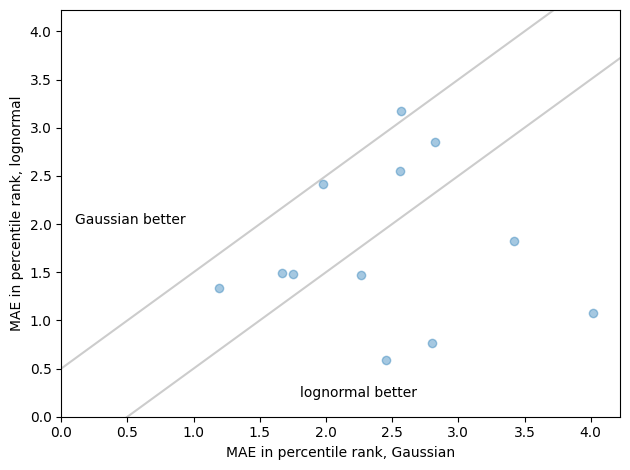

In [39]:
joined = join(gaussian, lognormal)
scatterplot(joined)
plt.savefig("log_vs_normal8.png", dpi=300)

In [40]:
(joined["diff"] > 0).mean()

0.6666666666666666

In [41]:
joined.sort_values(by="diff", inplace=True)
joined.head(3)

,error_gaussian,sex,measurement,error_lognormal,diff,sum
6,2.569561,female,Hb,3.168235,-0.598674,5.737797
0,1.976727,male,Hb,2.415662,-0.438935,4.392390
10,1.191881,female,Crea,1.335989,-0.144108,2.527870


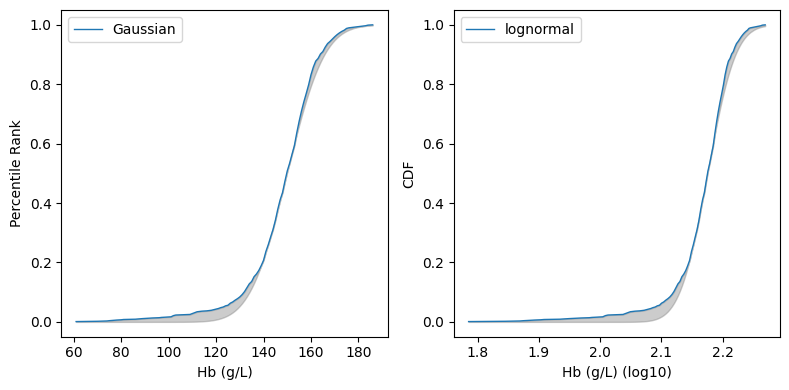

In [42]:
# Gaussian better (but both bad)

name = "Hb"
make_double_plot(lab.loc[male, name], label_dict[name])

In [43]:
joined.tail()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
4,2.267264,male,Crea,1.466140,0.801124,3.733404
11,3.419685,female,ALAT,1.826160,1.593525,5.245845
7,2.454356,female,WBC,0.586840,1.867516,3.041196
1,2.800216,male,WBC,0.767287,2.032929,3.567503
5,4.020443,male,ALAT,1.079603,2.940840,5.100046


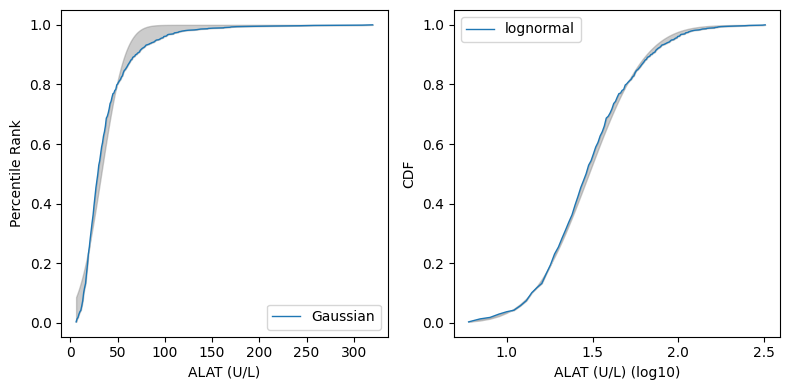

In [44]:
# lognormal better

name = "ALAT"
make_double_plot(lab.loc[male, name], label_dict[name])

In [45]:
joined.sort_values(by="sum", inplace=True)
joined.head()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
10,1.191881,female,Crea,1.335989,-0.144108,2.527870
7,2.454356,female,WBC,0.586840,1.867516,3.041196
9,1.670563,female,K,1.487594,0.182969,3.158158
3,1.751536,male,K,1.486174,0.265362,3.237710
1,2.800216,male,WBC,0.767287,2.032929,3.567503


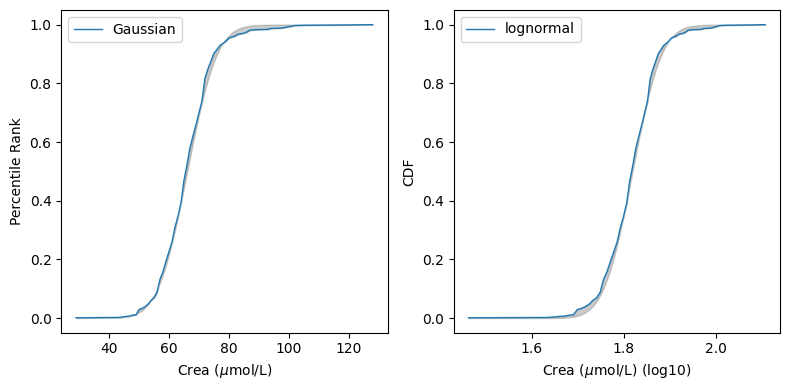

In [46]:
# Both good

name = "Crea"
make_double_plot(lab.loc[female, name], label_dict[name])

In [47]:
joined.tail()

,error_gaussian,sex,measurement,error_lognormal,diff,sum
5,4.020443,male,ALAT,1.079603,2.940840,5.100046
8,2.558988,female,Na,2.551349,0.007639,5.110336
11,3.419685,female,ALAT,1.826160,1.593525,5.245845
2,2.826943,male,Na,2.850049,-0.023105,5.676992
6,2.569561,female,Hb,3.168235,-0.598674,5.737797


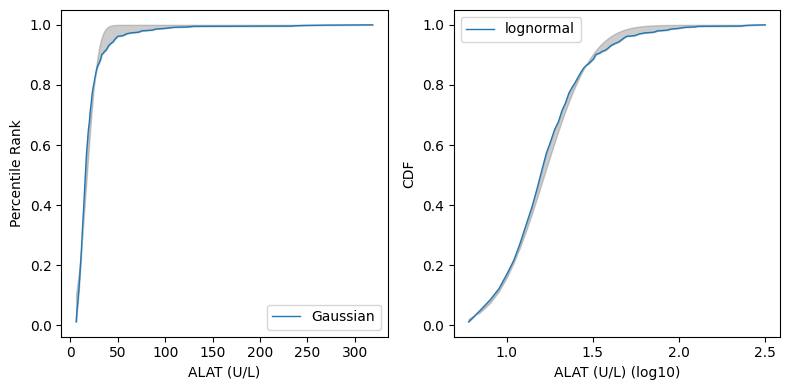

In [48]:
# both bad (but lognormal better)

name = "ALAT"
make_double_plot(lab.loc[female, name], label_dict[name])

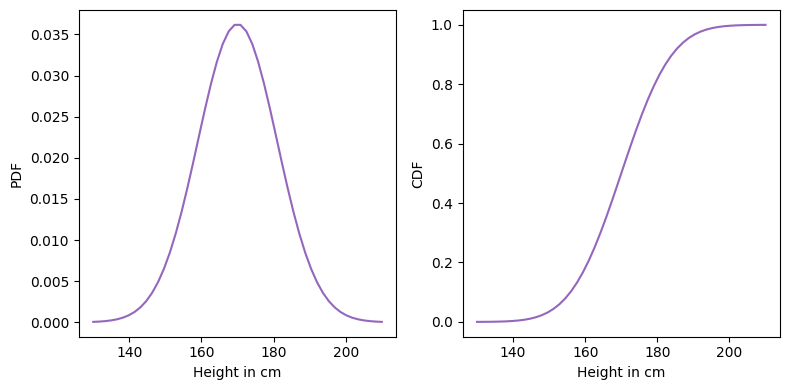

In [49]:
dist = norm(170, 11)
xs = np.linspace(130, 210)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
ps = dist.pdf(xs)
plt.plot(xs, ps, color="C4")
decorate(ylabel="PDF", xlabel="Height in cm")

plt.subplot(1, 2, 2)
ps = dist.cdf(xs)
plt.plot(xs, ps, color="C4")
decorate(ylabel="CDF", xlabel="Height in cm")

plt.tight_layout()
plt.savefig("log_vs_normal10.png", dpi=300)

Here's a version of the model-fitting code that's easier to walk through.

In [50]:
from empiricaldist import Cdf

cdf_data = Cdf.from_seq(series)

low, high = series.quantile([0.01, 0.99])
qs = np.linspace(low, high)
ps = cdf_data(qs)

In [51]:
from scipy.stats import norm


def error_func(params):
    print(params)
    cdf_model = norm(*params).cdf
    error = cdf_model(qs) - cdf_data(qs)
    return error

In [52]:
from scipy.optimize import least_squares


def fit_model(series):
    x0 = series.mean(), series.std()
    res = least_squares(error_func, x0=x0, xtol=1e-3, loss="soft_l1")
    return res.x

In [53]:
series = ansur_male["stature"]
fit_model(series)

[1756.21460069   68.55078767]
[1756.21462686   68.55078767]
[1756.21460069   68.55078869]


array([1756.21460069,   68.55078767])

The following figures help explain the parameter estimation method

In [54]:
cdf_data = Cdf.from_seq(series)

low, high = series.quantile([0.01, 0.99])
qs = np.linspace(low, high, 11)
ps_data = cdf_data(qs)

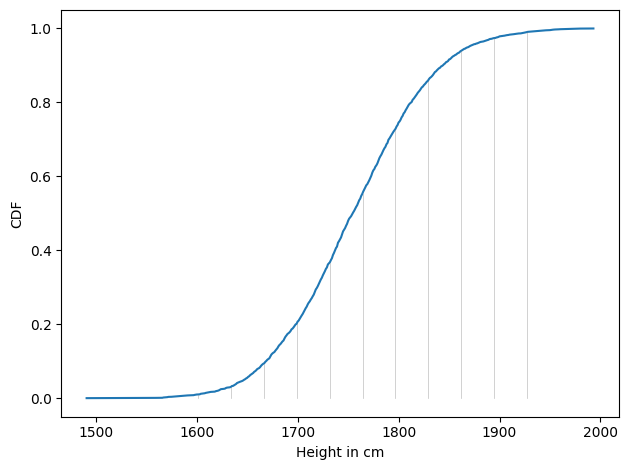

In [55]:
cdf_data.plot()

for p, q in zip(ps_data, qs):
    xs = [q, q]
    ys = [p, 0]
    plt.plot(xs, ys, color="gray", lw=0.5, alpha=0.5)

decorate(xlabel="Height in cm", ylabel="CDF")
plt.savefig("log_vs_normal6.png", dpi=300)

In [56]:
x0 = series.mean(), series.std()
x0

(1756.2146006859382, 68.55078766890092)

In [57]:
cdf_model = norm(1750, 100).cdf
ps_model = cdf_model(qs)

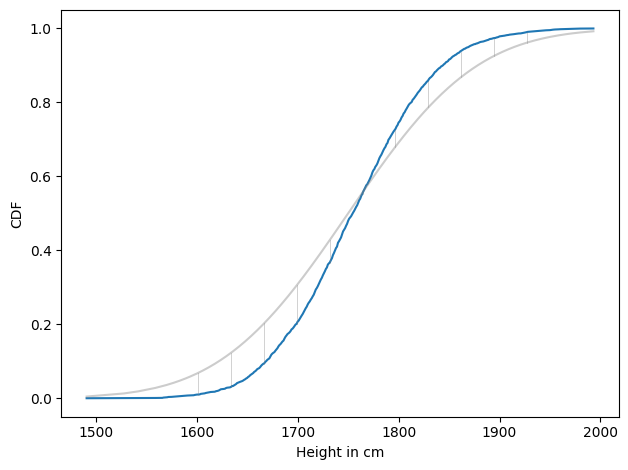

In [58]:
cdf_data.plot()


def plot_model(cdf, qs):
    ps = cdf_model(qs)
    plt.plot(qs, ps, color="gray", alpha=0.4)


plot_model(cdf_model, cdf_data.index)

for p0, p1, q in zip(ps_data, ps_model, qs):
    xs = [q, q]
    ys = [p0, p1]
    plt.plot(xs, ys, color="gray", lw=0.5, alpha=0.5)

decorate(xlabel="Height in cm", ylabel="CDF")

plt.savefig("log_vs_normal7.png", dpi=300)

Probably Overthinking It: The Puzzles and Paradoxes of Probability

Copyright 2022 Allen Downey 

